# Bioinformatics project - second part
### Nom : Madalin Ionescu
### Matricule : 000442828
## Introduction
In the first part of this project we implemented the Needleman-Wunsch and Smith-Waterman algorithms for pairwise sequence alignments. These are base methods in the processus of similarity and evolutionary homology detection. In order to implement the two functions, for global and local alignments respectively, we used the dynamic programming technique. We then discussed what the different substitution matrices represent and the main differences between them, as well as their ideal use case and which is the most suitable in order to maximise the identity and similarity scores of the local and global alignment respectively. The use of the **global alignment** allowed us the select the most similar BRD domains from a given list of amino acids sequences. Last but not least, we used the pairwise **local alignment** to discover the high similarity between the Bromo domain in different proteins. We are now going to improve this last section of the previous part by taking into account multiple sequences.

In order to proceed to the methods used in this second part, we must first introduce the key concepts and informations needed for a good understanding of the further implementaion. A central concept of this project is the **protein domain**, which we briefly introduced in the previous part as *an element of the protein general structure, self-stabilizing and folding independently of the rest of the protein.* To complete this definition, we can say that the structural domains are incorporated as modules in different proteins, forming a sort of mosaics of various types of pieces(domains), that confer distinct properties and thus can perform **different functions** simultaneously. From a functional point of view, the structural domains might frequently have an activity independent of the rest of the protein.

Even if we can say that the *same* domain might be present in different proteins, the word *same* has a too strong meaning here since, in the cours of evolution, **many gene coding segments have been shuffled**. Given that, the are multiple distinct sequences coding for the same domain, so a simple pairwise alignment between a well known protein containg a domain and a test one might not reveal any significant similarities, even if the second protein also contains the domain in cause. For this reason, we must introduce the multiple sequence alignment method, which does not take into consideration only two sequences (a reference and a test sample), but multiple. This way we increase the volume of information on which each alignment is based.

The technique of **Multiple sequence alignment**, shortened **MSA**, represents, as stated previously, a sequence alignment of more than two protein amino acids sequences, differentiating it from our initial implementation which took into consideration only pairs of sequences. The objective of this method is homology inference and shared evolutionary origin assessment, as well as the study of sequence conservation, protein domains and secondary and tertiary structure. The greatest problem an MSA imposes is the fact that they use **heuristic implementations**, which do not guarantee the best result, instead of normal techniques like the dynamic programming, due to the extremely **high computational complexity**.

**PSSM** is the abbreviation for **Position Specific Scoring Matrices**, which are a specific type of matrices used to store a MSA. Concretely, we can view the PSSMs as a more convenient way to summarize the result of a multiple sequence alignment, result which can be further used to align a new sequence to the group with a dynamic programming technique just as in the first part.

Because we introduced the notion of *PSSM*, we must also introduce a complementary concept to it, the **pseudocounts**. A pseudocount is a term for nonexisting data, which is added to the real data in an attempt to overcome the possible problems related to the lack of actual information (the lack of real data). We will present in a further section different ways to implement this concept and how they affect the scores inside the PSSM. We must also note that, since the only difference between a PSSM and a profile is the insertion of a new column representing the position dependent gap penalty, we will use these two 'names' interchangeably throughout this repport, even if 'profile' is a better noun for this project.

We can now present the materials and methods we are going to use to achieve the goal of this second part of our project, namely the **construction of a profile** in the form of a PSSM matrix, with an additional column, from a MSA and the use of this profile to **find Bromo domains** in a pair of protein sequences.

# Material and Methods
### Required libraries and Abstract Data Types
Since this paper represents a continuation of our first incursion into the protein sequence alignment topic, namely _Bioinformatics project - first part_, all the modules utilized earlier and all the defined ADTs must be imported. In order to achieve this, we must do a slight code reorganization, so that all the methods and data types previously used are now part of the file ***part1.py***. Aditionally, we will use the **time** library to compare the execution time of different parts and some mathematic functions, part of the **math** library.

In [1]:
''' Import the ADTs and the methods used in the first part, as well as
    the required modules: numpy (np), itertools (it), os, pandas (pd),
    math, matplotlib.pyplot (plt) and Image
'''
%run part1.py

sqrt = math.sqrt
log = math.log
exp = math.exp

In order to satisfy the new demands implied by this extension of the first part, we must append some new methods and abstract data types, as well as modify some of the already existing parts. The added methods target the ***Score_Matrix*** ADT. They are supposed to facilitate the access to different scores (being simple *getters*), but otherwise they do not add any new functionality to our implementation. On the other hand, functions covering the alignment of a sequence to a **P**osition **S**pecific **S**coring **M**atrix must be added, as well as some minor modification to the constructor and the displaying function, but all these will be discussed later in this repport.

In [2]:
def get_identity_score(self) :
    if hasattr(self, '_global_solution') and len(self._global_solution) != 0 :
        return self._global_solution[0][3]
    elif hasattr(self, '_local_solution') and len(self._local_solution) != 0 :
        return self._local_solution[0][3]
    
Score_Matrix.get_identity_score = get_identity_score

def get_similarity_score(self) :
    if hasattr(self, '_global_solution') and len(self._global_solution) != 0 :
        return self._global_solution[0][4]
    elif hasattr(self, '_local_solution') and len(self._local_solution) != 0 :
        return self._local_solution[0][4]
    
Score_Matrix.get_similarity_score = get_similarity_score

def get_matrix_score(self) :
    if hasattr(self, '_global_solution') and len(self._global_solution) != 0 :
        return self._global_solution[0][5]
    elif hasattr(self, '_local_solution') and len(self._local_solution) != 0 :
        return self._local_solution[0][5]
    
Score_Matrix.get_matrix_score = get_matrix_score

#### The new constructor for Score_Matrix

In [3]:
def score_mat_init(self, seq1, seq2, penalty, subst_matrix, profile_alignment = False) :
    """ Initially, the main matrix contains only zeros, while V and W
        contain zeros, with the exception of the first column/ row, which
        is fille with a value equivalent to negative infinity.
        Attention : penalty is positive
    """
    if not profile_alignment :
        matrix = [[0 for i in range(seq1.len() + 1)] for j in range(seq2.len() + 1)]
        Matrix.__init__(self, seq1, seq2, matrix)
        self._columns.insert(0,'-')
        self._rows.insert(0,'-')
        self._penalty = penalty           #a couple : I = penalty[0], E = penalty[1]
        self._subst_matrix = subst_matrix #a substitution matrix

        self._V = [[0 for i in range(self._columns.len())] for j in range(self._rows.len())]
        for i in range(self._columns.len()) :
            self._V[0][i] = - math.inf    #first row contains - infinity

        self._W = [[0 for i in range(self._columns.len())] for j in range(self._rows.len())]
        for j in range(self._rows.len()) :
            self._W[j][0] = -math.inf     #first column contains - infinity
    else :
        matrix = [[float(0) for i in range(seq1.len() + 1)] for j in range(seq2.len() + 1)]
        Matrix.__init__(self, seq1, seq2, matrix)
        self._columns.insert(0,'-')
        self._rows.insert(0,'-')
        self._penalty = None              #None, because the penalty is stored into the profile
        self._subst_matrix = subst_matrix #the profile
        
Score_Matrix.__init__ = score_mat_init

We chose to create a new specialization of our previously defined ADT *Matrix*, called ***Similarity_Matrix***, which will append the possibility to avoid calculating the similarity score between the same pair of sequences twice. This optimization technique will be used while computing the biggest group of sequences having at most a specified similarity score (percentage), which we will discuss, again, later. As revealed by the the way the matrix is filled up, it has symmetric structure, so the insertion, and implicitly the calcul of similarity, of a new pair will automacally cover for the calcul of the mirrored pair of amino acids, in which they are presented in opposite order.

In [4]:
class Similarity_Matrix(Matrix) :
    """ Matrix used to store the similarity score for already calculated
        pairs of sequences.
    """
    def __init__(self, seq_nb) :
        self._columns = [i for i in range(seq_nb)]
        self._rows = [i for i in range(seq_nb)]
        self._matrix = np.matrix([[None for i in range(seq_nb)] for j in range(seq_nb)])
    def __setitem__(self, acids, value) :
        self._matrix[self._rows[acids[0]], self._columns[acids[1]]] = value
        self._matrix[self._rows[acids[1]], self._columns[acids[0]]] = value

The following abstract data type, **Pseudo_Sequence** is to be used to represent False sequences, which all respect the structure of an amino acids sequence and can be used as one inside other ADTs, but do not necessarily contain amino acids residues. For example, we will use throughout this project a pseudo sequence containing all the positions in a PSSM, so a sequence of numbers instead of amino acids. This new ADT is justified by the limitations of the previously implemented ones, which did not take into consideration the new objectives we have for the second part of the project.

In [5]:
class Pseudo_Sequence(Sequence) :
    """ False amino acids sequence used for the alignment with
        a profile
    """
    def __init__(self, length = None) :
        if length == None :
            # we want a sequence with all the proteinogenic acids + gap
            # in order to create a Profile
            acids = 'ACDEFGHIKLMNPQRSTVWY-'
            description = '> Proteinogenic amino acids for the PSSSM, including gap at the end'
        else :
            # sequence with all the positions in the profile
            acids = [str(i) for i in range(length)]
            description = "> Positions in the Profile"
        super().__init__(acids, description)

### The Position Specific Scoring Matrix
As presented earlier, the main goal of this project is to implement an alignment of one protein sequence to a group of other sequences represented by a profile, but in order to achive this, we must first present how to implement the PSSM abstract data type and how to calculate it from the MSA sequences. Structurewise, a profile is specialization of the type **Matrix**, in which the columns represent the **20 proteinogenic amino acids in standard genetic code**, plus and extra one for the gaps, and the rows represent each **position in the multiple sequence alignment**.
This new ADT should be used in a similar manner to the **Score_Matrix** type presented in the first part, since the profile alignment algorithm can be seen as a variation of the *Smith-Waterman* algorithm. Starting from this supposition and analyzing the character of the scores in a score matrix - concretely each score is calculated as an log odds ratio - we easily come to the conclusion that each position in the profile should also be calculated as a **log odds ration**, with respect to the formula :

$$m_{u,a} = log \frac{q_{u,a}}{p_a}\mbox{ , where }\begin{cases}q_{u,a}\mbox{ is the probability of residue }a\mbox{ occuring on column }u\mbox{ of the PSSM} \\ p_a\mbox{ is the probability of residue }a\mbox{ occuring anywhere}\end{cases}$$

To conclude the PSSM's structure and the form of its content, we can simply say that each value in the profile is a weighted function of the values of a normal substitution matrix.

We will now present a hand full of manners of implementing the previous formula, but before that we should mention that the value of the probability of an amino acid occuring anywhere in any sequence is obtained using the **Swissprot** database, since the data we posses is not abundant, so the calculated relative frequency does not match the probability (further details in the *Discussion*).

In [6]:
class Profile(Matrix) :
    """ Implementation of the PSSM with a supplementary column indicating
        the penality to place a gap on a specific position.
    """
    def len(self) :
        """ Return the number of positions in the profile.
        """
        return self._rows.len()
    
    def fill_matrix(self) :
        """ Calculate each score in the PSSM. Normally called when
            the profile is built via __init__
        """
        for i in range(self._rows.len()) :
            for j in range(20) :
                a = self._columns[j]
                self._matrix[i][j] = log(self.q_simplified_1(i,a)/self.probability_dict[a])*10
                
    def q_complex(self) :
        """ Avoid not defined errors """
        pass
        
    def q_simplified_1(self) :
        """ Avoid not defined errors """
        pass
        
    def q_simplified_2(self) :
        """ Avoid not defined errors """
        pass
        
    def q_simplified_no_beta(self) :
        """ Avoid not defined errors """
        pass

    def __init__(self, sequences, subst_matrix, matrix_lambda, gap_penalty = -9, fun = 1, probability_dict = \
                 {'A':0.0825, 'R':0.0553, 'N':0.0406, 'D':0.0545, 'C':0.0137,\
                  'Q':0.0393, 'E':0.0675, 'G':0.0707, 'H':0.0227, 'I':0.0596,\
                  'L':0.0966, 'K':0.0584, 'M':0.0242, 'F':0.0386, 'P':0.0470,\
                  'S':0.0656, 'T':0.0534, 'W':0.0108, 'Y':0.0292, 'V':0.0687}) :
        """ The construction of a profile will also run the function used
            to calculate its contents so it might take a few moments.
        """
        self.sequences = sequences
        self.subst_matrix = subst_matrix
        self.matrix_lambda = matrix_lambda
        self.probability_dict = probability_dict
        self._rows = Pseudo_Sequence(self.sequences[0].len())
        self._columns = Pseudo_Sequence()
        if gap_penalty > 0 :
            gap_penalty = - gap_penalty
        if fun == 1 :
            self.q = self.q_complex
        elif fun == 2 :
            self.q = self.q_simplified_1
        elif fun == 3 :
            self.q = self.q_simplified_2
        else :
            self.q = self.q_simplified_no_beta
        self._matrix = [[gap_penalty for i in range(21)] for i in range(self._rows.len())]
        self.fill_matrix()
        self._matrix = np.matrix(self._matrix)

The denominator of the fraction used to compute the scores inside the profile can be calculated in multiple ways as emphasized by the follwing formulas, presented in descending order of their complexity: 

$$\mbox{[1] :}\quad q_{u,a} = \frac{\alpha f'_{u,a} + \beta g_{u,a}}{\alpha + \beta}\qquad
\mbox{[2] :}\quad q_{u,a} = \frac{\alpha f_{u,a} + \beta p_a}{\alpha + \beta}\qquad
\mbox{[3] :}\quad q_{u,a} = \frac{n_{u,a} + \beta p_a}{N_{seq} + \beta}\qquad
\mbox{[4] :}\quad q_{u,a} = \frac{n_{u,a} + 1}{N_{seq}+20}$$

$$\mbox{where :}\quad \mbox{*}\quad f_{u,a}=\frac{n_{u,a}}{N_{seq}}\qquad
\mbox{**}\quad f'_{u,a}=\frac{n_{u,a}+1}{N_{seq}}\qquad
$$

The formula \* represents nothing other than **relative frequency** of the amino acid *a* on the position *u* in the MSA sequences. The problem is that, when there is no amino acid of type *a* on the position *u* in any of the sequences, the relative frequency will be 0, but when replacing *f* in a formula where all the termes are multiples of *f*, we would try to compute *log(0)*, equalling minus infinity. Of course, such a score is not allowed in the profile, that's why we introduce the formula \*\*. The latter solves the problem of calculating **logarithm of zero**, but at the same time changes the real relative frequency of the amino acid *a* on the position *u*.

Because we explained the difference between the two 'sub-functions' for relative frequency, we can now point our attention to the main functions used to compute the likelyhood of an amino acid *a* to be found on the position *u* in one of the working sequences. By calculating the simple relative frequency, we might fall in the previously described case for the *f* function. In order to avoid this situation, we must use the concenpt of **pseudocount**, defined in *Introduction*. The most simple pseudocount we can imagine is thinking that all the amino acids have the same chances to be found on the specified position in a sequence, leading to the formula *[4]*, but a simple analysis of the percentages retrieved from the Swissprot database denotes the contrary: not all the amino acids appear in proteins at the same frequency.

The formula *[3]* gets rid of the naïve supposition used in the one previously described and introduces *β* as scalling parameter, which allows us to control the ratio between the importance of pseudocounts and the importance of the data. By developing even more this last idea of wheighting, we can introduce the formula *[2]*, which adds *α* as a secondary scalling parameter for the real data.

Last, but not least, the formula *[1]* adds yet again an improvement by combining last presented reasoning with the knowledge offered by the substitution matrices, which contain a more accurate information on the distribution, based on the data they where derived from.

In [7]:
def q_complex(self,u,a) :
    # slide Profils 12
    alpha = len(self.sequences) - 1
    beta = sqrt(len(self.sequences))
    return (alpha*self.f_prime(u,a) + beta*self.g(u,a))/(alpha + beta)

Profile.q = q_complex

def q_simplified_1(self,u,a) :
    # slide Profils 9
    alpha = len(self.sequences) - 1
    beta = sqrt(len(self.sequences))
    return (alpha*self.f(u,a) + beta*self.probability_dict[a])/(alpha + beta)

Profile.q_simplified_1 = q_simplified_1

def q_simplified_2(self,u,a) :
    # slide Profils 8
    nseq = len(self.sequences)
    beta = sqrt(len(self.sequences))
    return (nseq*self.f(u,a) + beta*self.probability_dict[a])/(nseq + beta)

Profile.q_simplified_2 = q_simplified_2

def q_simplified_no_beta(self,u,a) :
    # slide Profils 9
    return (self.f(u,a)*len(self.sequences) + 1)/(len(self.sequences) + 20)

Profile.q_simplified_no_beta = q_simplified_no_beta

The functions *f* and *f_prime* defined below represent the implementation of the previously discussed formulas \* and \*\*.

In [8]:
def f(self,u,a) :
    """ Relative frequency of the amino acid a on the position u.
    """
    n = 0
    for sequence in self.sequences :
        if sequence[u] == a :
            n += 1
    return n/len(self.sequences)

Profile.f = f

def f_prime(self,u,a) :
    """ Relative frequency of the amino acid a on the position u,
        modified in order to avoid zero values.
    """
    n = 1
    for sequence in self.sequences :
        if sequence[u] == a :
            n += 1
    return n/len(self.sequences)

Profile.f_prime = f_prime

The following function is used to derive data from the substitution matrices based on the idea that each position score is computed as a **log odds ratio** : 

$$S(a,b)=log\frac{q_{a,b}}{p_a p_b}$$

Since we are trying the derive the original results by deconstructing the score, we need to apply the inverse function, *exp()*, not forgetting about the scalling factor of the substitution matrices, *λ*, which in our case, for the *BLOSUM80* matrix, is half bit or, in other words, *ln(2)/2*. We are obtaining the following formula :

$$\mbox{***}\quad g_{u,a}=\sum_b f'_{u,b} \frac{q_{a,b}}{p_b}=\sum_b f'_{u,b} e^{\lambda s(a,b)} p_a$$

In [9]:
def g(self,u,a) :
    s = 0
    for i in range(20) :
        b = self._columns[i]
        s += self.f_prime(u,b)*(exp(self.matrix_lambda*self.subst_matrix[a,b]))*self.probability_dict[a]
    return s

Profile.g = g

### The WEBLOGO
The **WEBLOGO** is a graphical representation of the sequence conservation of amino acids in proteins. In other words, it represents a graphical version of our PSSM. 

### The sorting algorithm
The base dataset for our project consists of 223 sequences in *FASTA* format, obtained from the **SMART** database.

In order to compute the multiple sequence alignment and build our profile, we must first sort the set of sequences, keeping only the part of them displaying at most 60% similarity. To do this, we will use the **global alignment** implemented in the first part of this project and, as described then, the **BLOSUM80** matrix, since there are pairs of sequence with a similarity higher than 62%, which takes the BLOSUM62 matrix our of discussion.

One possible method to filter the sequences might be by grouping them consecutively, as it follows: for each sequence, we try to add it in the already existing groups if it has less than 60% similarity with all the members of the group. We then create a new group with the new sequence. The creation of this new group will allow next sequences to enter a group if they are not similar with the current one, even if they have a high similarity with the previous sequences (not taking into the consideration the current one). When all sequences are compared, we will have multiple groups, most likely of different legths, which contain all sequences satisfying the similarity property. Since we want to have a reference as large as possible, in order to be more precise when aligning the given sequences with the PSSM, we should choose as group of sequences for the MSA (and then for the profile) the biggest one, and write them it the file *to-be-aligned-reduced.fasta*.

Although this method obtains a good group of sequences, we can not guarantee its ability to give the best result, since it is dependent on the order in which the sequences are presented. On the other hand, using backtracking for example in such a case would be impossible, due to the extreme size of the computational complexity.

In [10]:
def filter_by_grouping(ipt='to-be-aligned', opt='to-be-aligned-reduced.fasta', \
                   penalty=[12,2], subst_matrix=matrix_dict['blosum80']) :
    """ Select from the input file only the group of sequences which
        are at most 60% similar and write them in the output file.
    """
    def get_similarity_score(seq_nb_1, seq_nb_2, already_calculated, penalty, subst_mat, ipt) :
        if already_calculated[seq_nb_1, seq_nb_2] == None :
            temp = Score_Matrix(sequence_dict[ipt][seq_nb_1], sequence_dict[ipt][seq_nb_2], penalty, subst_mat)
            temp.global_alignment(1)
            already_calculated[seq_nb_1, seq_nb_2] = temp.get_similarity_score()
            del temp
        return already_calculated[seq_nb_1, seq_nb_2]

    def get_max_group_length(seq_groups) :
        if len(seq_groups) == 0 :
            return 0
        else :
            return max([len(group) for group in seq_groups])

    print('────────────── COMPUTING THE REDUCED GROUP OF SEQUENCES ──────────────')
    calculated = Similarity_Matrix(len(sequence_dict[ipt]))
    seq_groups = []
    count = 0
    for new_seq in range(len(sequence_dict[ipt])) :
        group_nb = 0
        count += 1
        print('{0:.2f} % completed'.format(100*count/len(sequence_dict[ipt])), end='\r')
        while group_nb < len(seq_groups) :
            different = True
            for old_seq in seq_groups[group_nb] :
                different = different and get_similarity_score(old_seq, new_seq, calculated, \
                                                               penalty, subst_matrix, ipt) <= 60
            if different :
                seq_groups[group_nb].append(new_seq)
            group_nb += 1
        if get_max_group_length(seq_groups) < (len(sequence_dict[ipt]) - new_seq) :
            seq_groups.append([new_seq])
    print('100 % completed    \nWriting sequences to {}'.format(opt))
    max_length = get_max_group_length(seq_groups)
    for group in seq_groups :
        if len(group) == max_length :
            with open(opt, 'w') as reduced_file :
                for seq in group :
                    reduced_file.write(str(sequence_dict[ipt][seq]))
            break
    print('──────────────────────────────────────────────────────────────────────\n')

An alternative to this solution might be the folowing: we start with a group containing all the sequences. We then eliminate, at each step, the sequence which has more than 60% similarity with the most of other sequences. We repeat the second step until there are no more similar pairs. This idea is based on the fact that, by eliminating the sequences involved in the biggest number of pairs with high similarity, we are eliminating the most of the pairs with a minimum number of sequences or, in other words, we are minimizing the similarity, while maximising the number of kept sequences. By practically testing this alternative we obtain the same number of different sequences, 28, in a slightly longer time, so including it here, for the moment, does not make much sense.

### Online tools to obtain the MSA
The three online tools proposed for use to obtain the multiple sequence alignment are Clustal **Omega, TCoffee and MUSCLE**. All three of them are versions of progressive alignment tools. On the other hand, we chose to use *TCoffee* to align our sequences because of their small size, of less than 300 residus, and also because of the *TCoffee* affinity for improved progressive protein alignments.

### The consensus sequence
The consensus sequence represents the sequence of amino acids having the highest score on each position. In order to build score charts, we will also use the score associated with each of these positions.

In [11]:
def get_consensus_sequence(self) :
    res = [[],[]] 
    for pos in self._rows.to_list() :
        max = - math.inf
        dominant = None
        for aa in self._columns.to_list() :
            if self[pos, aa] > max :
                max = self[pos, aa]
                dominant = aa
        res[0].append(dominant)
        res[1].append(max)
    return res

Profile.get_consensus_sequence = get_consensus_sequence

### Computing a sequence alignment with a profile
The alignment between a given sequence and the profile can be seen as a modified version of the **local alignment** - also, we previously used it, during the first part, to find the alignment between a protein sequence and a Bromo domain. The reason we used the local alignment, instead of global one, it was the big difference in size between the two sequences, which is also the case now, and the fact that we only want to test the similarity for a *sub-sequence*, namely a domain. Actually, we can just summarize the sequence alignment with a profile, as the best way to match the amino acids in the sequence with the positions in the PSSM. 

In order to realize this, considering that we built our profile to be compatible with the way *Substitution_Matrix* was used before, we should replace the *Smith-Waterman* formula with the following one :

$$S(i,j) = max \begin{cases} S(i-1,j-1)+PSSM(seq(i),j) \\
                             S(i-1,j)+PSSM('-',j) \\
                             S(i,j-1)+PSSM('-',j-1) \\ 0
\end{cases}$$

In fact, compared to the local alignment, the main difference is that the gap penalty is also stored in the profile, making it possibly position dependent. This way, the block *PSSM('-',j)* translates into the score of puting a gap in the position *j*, while *PSSM(seq(i),j)* return the score of aligning the element on the *i* position in sequence on with the position *j* in the PSSM. It is worth mentioning that, due to the fact that our profile is in a transposed orientation, so the lines represent the position and the columns represent the residu, we should use an inversed notation, *PSSM(j,seq(i))*. We favorized the transposed version because it is easier to read when displayed in Jupyter Notebook.

In [12]:
def Profile_score(self, k = 1, l = 1, recompute = False) :
    if hasattr(self, '_last') :
        k = self._last[0]
        l = self._last[1]
        recompute = True
    for i in range(k, self._rows.len()) :
        for j in range(l, self._columns.len()) :
            if (recompute and self._matrix[i,j] != 0) or not recompute :
                self._matrix[i,j] = max(self._matrix[i-1,j-1] + self._subst_matrix[str(j-1),self._rows[i]], \
                                        self._matrix[i-1,j] + self._subst_matrix[str(j-1),'-'], \
                                        self._matrix[i,j-1] + self._subst_matrix[str(j-1),'-'], 0)
                
Score_Matrix.Profile_score = Profile_score

The next function represents just a **backtracking**, reconstructing the optimal alignment, just like the case of the local alignment. It is worth mentioning that, when arriving to a position in the score matrix from it's left, it's the equivalent of saying that we remained at the same place vertically or that we inserted a gap in the profile positions, which is not what we are interested in, so the alignment sequence remains unchanged.

In order to compare the positions of the found domains with the information available on Uniprot, we added a parameter to the backtracking function, which allows us to see the position of the aligned subsequence in the entire sequence.

Because a protein might contain multiple times a domain, we want to obtain not just the optimal alignment with the PSSM, but also the following ones, up a specified maximum number. In order to do this and to assure that no subparts of an already discovered alignment appear in a future suboptimal alignment, after a solution is completed, it's path in the score matrix is set to zero. This changement of values separates the old alignment from the new one and at the same time acts like a blocker, making impossible the insersion of subsequences of more optimal alignments into the further ones.

In [13]:
def align_with_Profile(self, k, i, j, seq = '', parent = [-1,-1], end = None) :
    if end == None :
        end = i
    if self._matrix[i,j] == 0 :
        if len(seq) >= 2 and len(self._Profile_solution) < k :
            self._Profile_solution.append([seq, i, end])
            self._last = parent
    else :
        if self._matrix[i,j] == (self._matrix[i-1,j-1] + self._subst_matrix[str(j-1),self._rows[i]]) :
            self.align_with_Profile(k, i-1, j-1, self._rows[i] + seq, [i,j], end)
        if self._matrix[i,j] == (self._matrix[i-1,j] + self._subst_matrix[str(j-1),'-']) :
            self.align_with_Profile(k, i-1, j, '-' + seq, [i,j], end)
        if self._matrix[i,j] == (self._matrix[i,j-1] + self._subst_matrix[str(j-1),'-']) :
            self.align_with_Profile(k, i, j-1, seq, [i,j], end) # gap in the profile -> alignment sequence unchanged
        self.replace_with_zero(i,j)
        
Score_Matrix.align_with_Profile = align_with_Profile

The following function is used to find more than one alignment. To achieve this goal, after a path is set to 0, the part of the score matrix at the right and under the last position in the old path is calculated. This is done by specifying the start position in a class attribute.

In [14]:
def Profile_alignment(self, k = 3) :
    self._Profile_solution = list()
    self.Profile_score()
    self._last = [1,1]
    maximum, i, j = self.get_max()
    while maximum != 0 and len(self._Profile_solution) < k :
        self.align_with_Profile(k, i, j)
        self.Profile_score()
        maximum, i, j = self.get_max()
        
Score_Matrix.Profile_alignment = Profile_alignment

We now have all the methods and materials necessary to filter our list of BRD human proteins, to create a MSA with these and further use them to derive a PSSM and align the two given sequences with the PSSM.

## Proof of concept and Results

In [15]:
#filter_by_grouping()

By executing *filter_by_grouping* function we were able to obtain 28 protein sequences with less than 60% similarity between them. Since the process of analyzing all the 223 base sequences takes a relatively long time, the result is already stored in the file *to-be-aligned-reduced.fasta*, while the original requences are stored in another file, namely *to-be-aligned.fasta*. Based on these files, we can use the online multiple sequence alignment tool *TCoffee*, in order to obtain their alignmenst, also in format *fasta*. They are stored, at their turn, in the files *msaresults-TCoffee.fasta* and *msaresults-reduced-TCoffee.fasta*.

By using the previously mentioned alignment, we can create 2 instances of the *Profile* abstract data type :

In [16]:
profile_reduced = Profile(sequence_dict['msaresults-reduced-TCoffee'],matrix_dict['blosum80'],log(2)/2,fun=2)
profile = Profile(sequence_dict['msaresults-TCoffee'],matrix_dict['blosum80'],log(2)/2,fun=2)

Since we created the two profiles, we can use them to align the two complementary sequences to them. As we can see further, the profile alignment finds the corresponding Bromo domains, or at least parts of them. The difference in terms of starting/ ending pointing of the found domain may be caused by an unsuitable gap value for exemple. By testing different gap values, we came to the conclusion that any value between 6 and 10 might be used with no problems, but a value of 8 or 9 reduces the number of gaps, without necessarily eliminating them. Also, by using the function *[2]* when calculating the profile values we achive a good compromise between precision and complexity, since the results are almost identical to the function *[1]*, but the complexity is significantly reduced.

In [17]:
seq1 = sequence_dict['protein-sequences'][0]
seq2 = sequence_dict['protein-sequences'][1]
pos = Pseudo_Sequence(profile.len())
pos_reduced = Pseudo_Sequence(profile_reduced.len())

print("Align sequence 1 with the extended profile: ")
a1 = Score_Matrix(pos, seq1, None, profile, True)
a1.Profile_alignment(2)
a1.pretty_print()

print("\nAlign sequence 1 with the reduced profile: ")
a2 = Score_Matrix(pos_reduced, seq1, None, profile_reduced, True)
a2.Profile_alignment(2)
a2.pretty_print()

print("\nAlign sequence 2 with the extended profile: ")
a3 = Score_Matrix(pos, seq2, None, profile, True)
a3.Profile_alignment(6)
a3.pretty_print()

print("\nAlign sequence 2 with the reduced profile: ")
a4 = Score_Matrix(pos_reduced, seq2, None, profile_reduced, True)
a4.Profile_alignment(6)
a4.pretty_print()

Align sequence 1 with the extended profile: 
1539 - 1585: YYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGP
1416 - 1462: YYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGP

Align sequence 1 with the reduced profile: 
1415 - 1462: DYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKN-ATYNGP
1538 - 1586: DYYKVIVNPMDLETIRKNISKHKYQSRE-FLDDVNLIL-NSVKYNGPE

Align sequence 2 with the extended profile: 
557 - 625: YYKIILEPMDLKIIEHNIRNDKYAGEE-MIEDMKLMFRNARHYNEEGSQVYNDAHILEKLLKEKRKEL
695 - 741: YYLTIKKPMDMEKIRSHMMANKYQDIDSMVEDFVMMFNNACTYNEP
419 - 466: YYQQIKMPISLQQIRTKLKNQEYETLDHLECDLNLMFENAKRYNVPN
219 - 265: YYAIIKEPIDLKTIAQRIQNGSYKSIHAMAKDIDLLAKNAKTYNEP
83 - 151: YYEVVSQPIDLMKIQQKLKMEEYDDVNLLTADFQLLFNNAKSYYKPDSPEYKAACKLWDLYLRTRNEF
816 - 881: KPPLTFDIIRKNVENNRYRRLDLFQEHMFEVLERARRMNRTDSEIYEDAVELQQFFIKIRDELCK

Align sequence 2 with the reduced profile: 
218 - 265: DYYAIIKEPIDLKTIAQRIQNGSYKSIHAMAKDIDLLAKNAKTYNEP
82 - 151: DYYEVVSQPIDLMKIQQKLKMEEYDDVNLLTADFQLLFNNAKSYYKPDSPEYKAACKLWDLYLRTRNEF
556 - 603: DYYKII-EPMDLKII

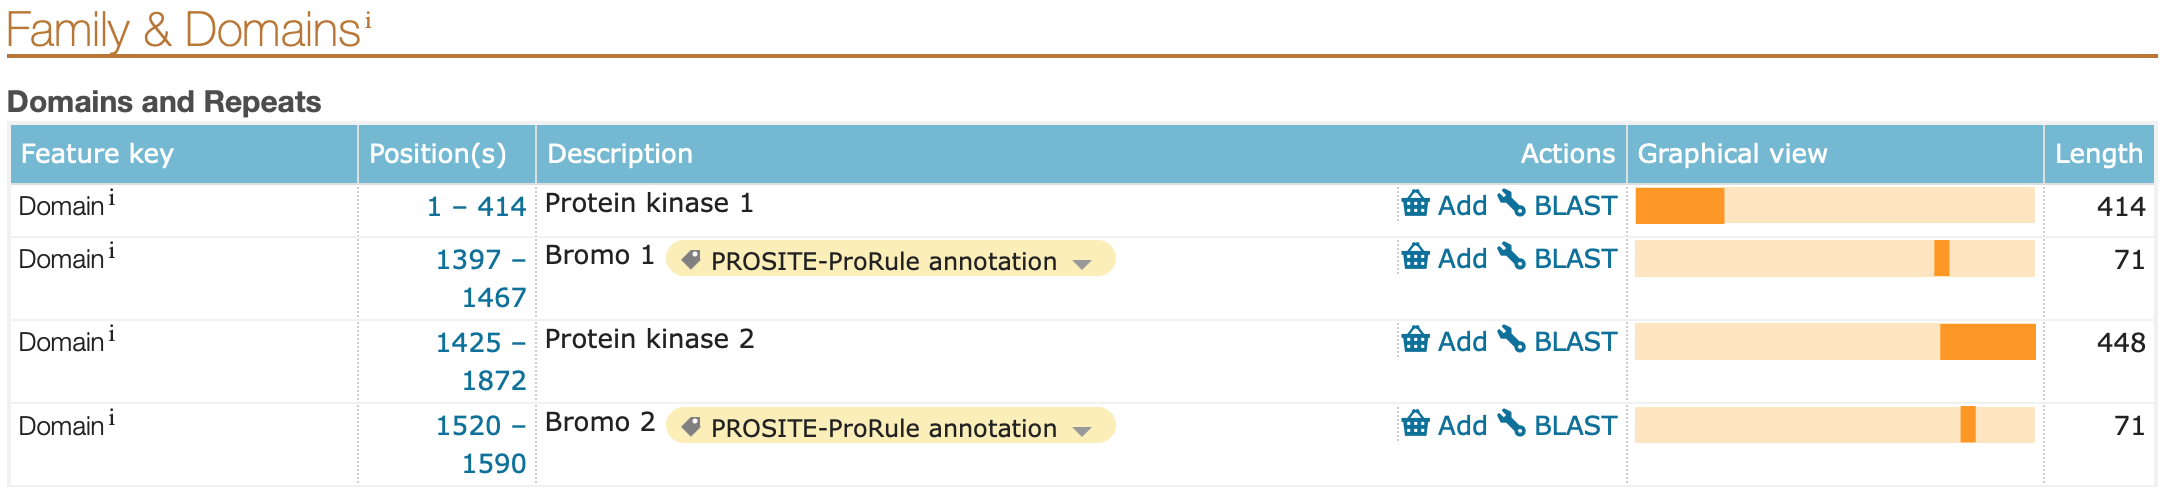

In [18]:
Image("P21675.png")

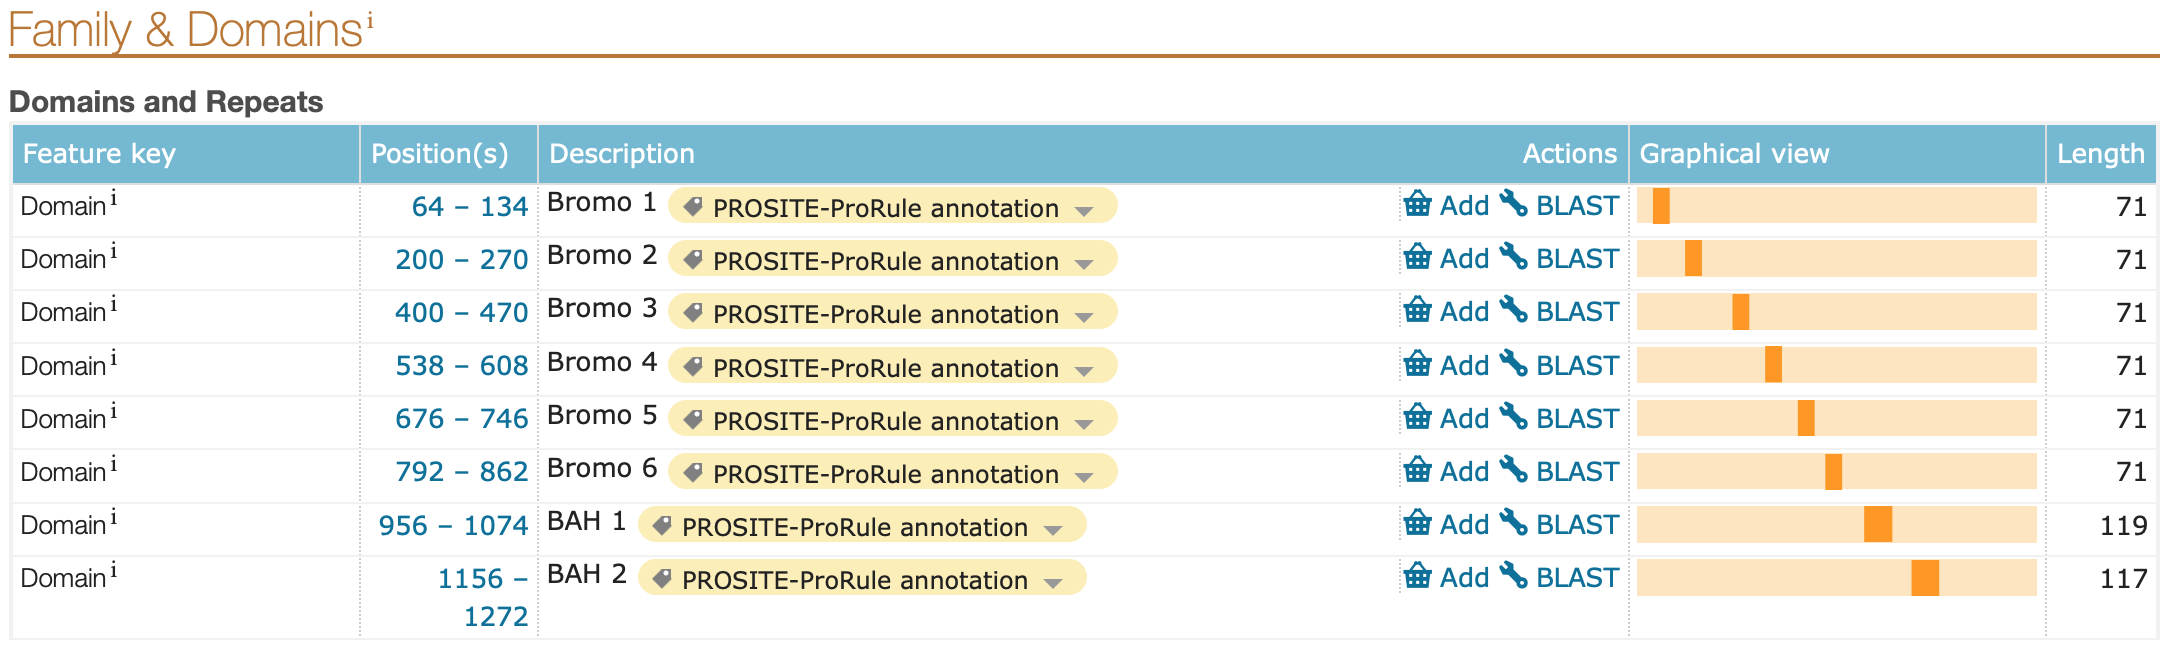

In [19]:
Image("Q86U86.png")

By consulting *UniProt*, we can verify that the domains are correctly found, but their extremities are a little bit moved, the right limit being generally close to the correct position, but the left one being usually around 20 position more to the right. Also, we can clearly see that the alignments using the reduced profile usually are a few positions longer. This might come from the fact that having very similar sequences in our alignment, the score of well conserved amino acids in certain positions will get very high, impending this way an alignment with another residu.

In [20]:
print(sequence_dict['protein-sequences'][0])
print(sequence_dict['protein-sequences'][1])

>sp|P21675|TAF1_HUMAN Transcription initiation factor TFIID subunit 1 OS=Homo sapiens OX=9606 GN=TAF1 PE=1 SV=2
MGPGCDLLLRTAATITAAAIMSDTDSDEDSAGGGPFSLAGFLFGNINGAGQLEGESVLDDECKKHLAGLGALGLGSLITELTANEELTGTDGALVNDEGWVRSTEDAVDYSDINEVAEDESRRYQQTMGSLQPLCHSDYDEDDYDADCEDIDCKLMPPPPPPPGPMKKDKDQDSITGEKVDFSSSSDSESEMGPQEATQAESEDGKLTLPLAGIMQHDATKLLPSVTELFPEFRPGKVLRFLRLFGPGKNVPSVWRSARRKRKKKHRELIQEEQIQEVECSVESEVSQKSLWNYDYAPPPPPEQCLSDDEITMMAPVESKFSQSTGDIDKVTDTKPRVAEWRYGPARLWYDMLGVPEDGSGFDYGFKLRKTEHEPVIKSRMIEEFRKLEENNGTDLLADENFLMVTQLHWEDDIIWDGEDVKHKGTKPQRASLAGWLPSSMTRNAMAYNVQQGFAATLDDDKPWYSIFPIDNEDLVYGRWEDNIIWDAQAMPRLLEPPVLTLDPNDENLILEIPDEKEEATSNSPSKESKKESSLKKSRILLGKTGVIKEEPQQNMSQPEVKDPWNLSNDEYYYPKQQGLRGTFGGNIIQHSIPAVELRQPFFPTHMGPIKLRQFHRPPLKKYSFGALSQPGPHSVQPLLKHIKKKAKMREQERQASGGGEMFFMRTPQDLTGKDGDLILAEYSEENGPLMMQVGMATKIKNYYKRKPGKDPGAPDCKYGETVYCHTSPFLGSLHPGQLLQAFENNLFRAPIYLHKMPETDFLIIRTRQGYYIRELVDIFVVGQQCPLFEVPGPNSKRANTHIRDFLQVFIYRLFWKSKDRPRRIRMEDIKKAFPSHSESSIRKRLKLCADFKRTGMDSNWWVLKSDFRLPTEEEIRAMVSPEQCCAY

## Discussion

### Profile vs. Weblogo vs. HMMlogo
We are now going to present the *Weblogos* for our 2 profiles and their increased similarity with the charts obtained from the following function. But before that we must introduce the *HMMlogo*, *HMM* standing for *Hidden Markovian Models*, a statistical model.

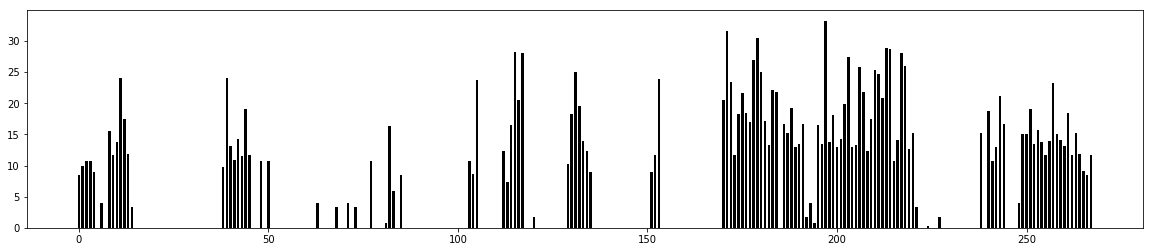

In [21]:
def profile_chart(profile) :
    """ Used to produce a graphical representation of the profile : 
        horizontally we have the PSSM position and vertically its
        correspondent score.
    """
    seq, score = profile.get_consensus_sequence()
    plt.figure(figsize=(20,4))
    plt.bar([i for i in range(len(seq))], [(i if i > 0 else 0) for i in score], 1/1.5, color="black")

profile_chart(profile_reduced)

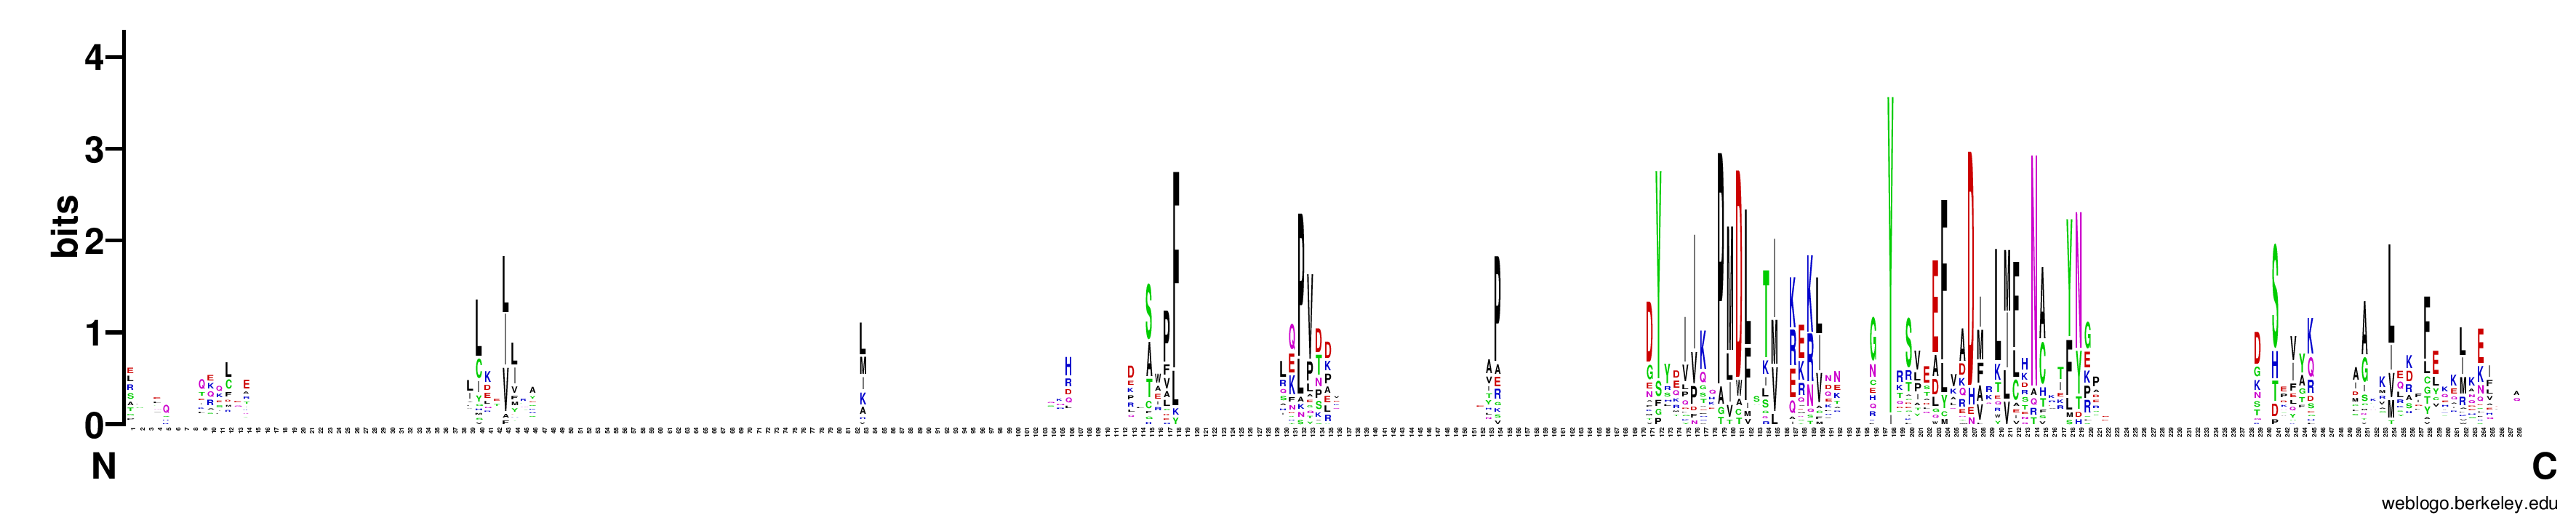

In [22]:
Image("weblogo-reduced.png")

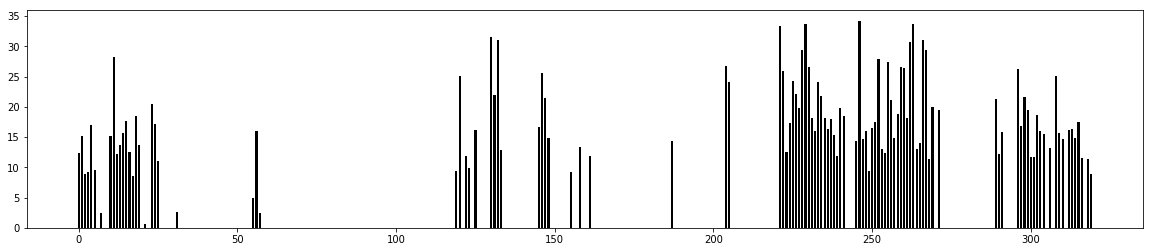

In [23]:
profile_chart(profile)

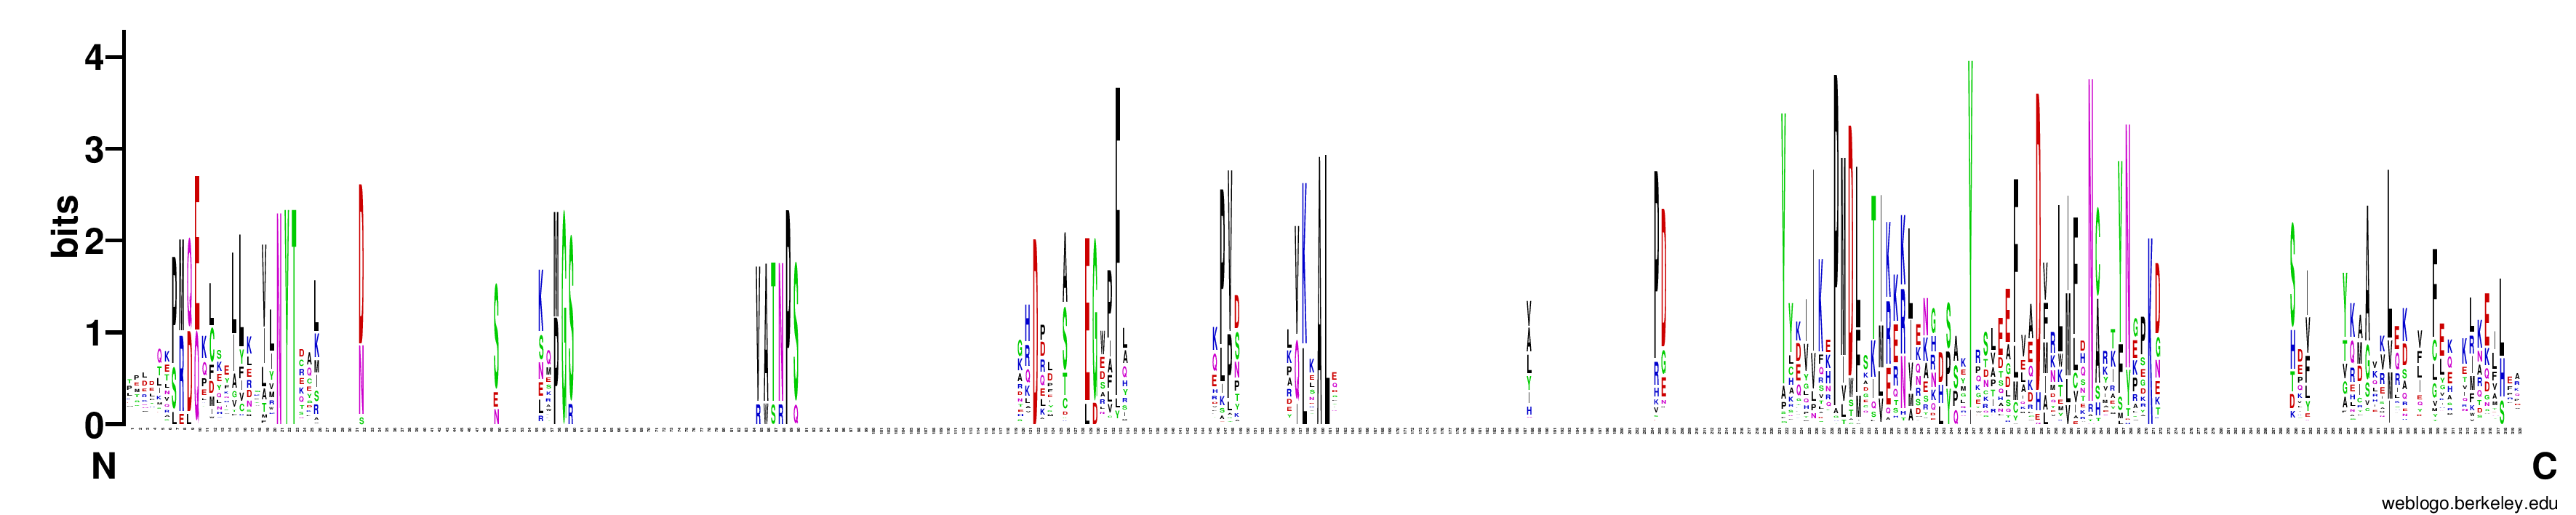

In [24]:
Image("weblogo.png")

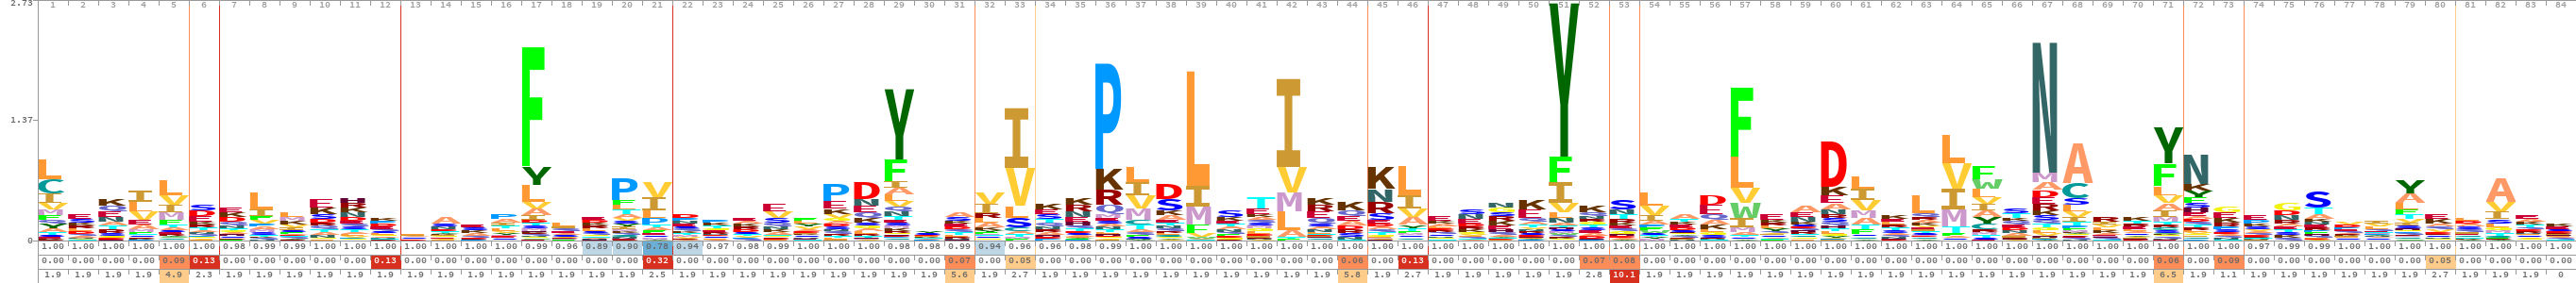

In [25]:
Image("HMMlogo.png")

The analysis of our graphical representation in comparison to the *WEBLOGO* reveal a similar structure, not being perfectly identical being something normal, since the 2 implementations use different methods. Also, by analyzing the chart we can find the probable reason why the left limit of the domains we found is about 20 positions off its supposed location: the chart also displays an empty area at the left, signifying negative scores.

Nevertheless, by comparing the *HMMlogo* and *WEBLOGO*, we can see that the succession of the most important residues in the first one is actually the same as in the second, regarding just the right part of the *WEBLOGO*, the part of high density acids with higher scores, which is also represented in our chart.

### Comparison between probability obtained from local dataset and Swissprot data

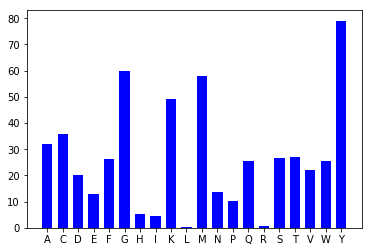

In [26]:
def calculate_relative_frequency() :
    count = dict()
    for i in 'ACDEFGHIKLMNPQRSTVWY' :
        count[i] = 0
    for seq in sequence_dict['to-be-aligned'] :
        for aa in seq.to_list() :
            count[aa] += 1
    total = 0
    for i in count.values() :
        total += i
    percentage = dict()
    for i in count.keys() :
        percentage[i] = count[i]/total
    return percentage

def compare_freq_swissprot(probability_dict = {'A':0.0825, 'R':0.0553, 'N':0.0406, 'D':0.0545, 'C':0.0137,\
                                               'Q':0.0393, 'E':0.0675, 'G':0.0707, 'H':0.0227, 'I':0.0596,\
                                               'L':0.0966, 'K':0.0584, 'M':0.0242, 'F':0.0386, 'P':0.0470,\
                                               'S':0.0656, 'T':0.0534, 'W':0.0108, 'Y':0.0292, 'V':0.0687}) :
    local = calculate_relative_frequency()
    difference_dict = dict()
    for i in local.keys() :
        difference_dict[i] = round(abs((local[i]-probability_dict[i])/probability_dict[i]*100),2)
    plt.bar(list('ACDEFGHIKLMNPQRSTVWY'), difference_dict.values(), 1/1.5, color="blue")
    
compare_freq_swissprot()

The above chart displays the difference in percentages, relative to the Swissprot data, between the locally calculated amino acid probability and the dataset obtained from the above mentioned database.

In order to understand the big differences between the results obtained from our limited dataset and the Swissprot results, we must review the phenomenon of statistical convergence: the relative frequency of a variable becomes equal to its probability when the number of samples tends to infinity. Obviously, the differences we see here come from the fact that the number of sequences we analyze is relatively small compared to database taken as reference. But even using the Swissprot numbers does not guarantee perfect accuracy since this database is evolving continuously. For example, by comparing the values in the given documentation (on the slide 27) with the present day values we are able to see some differences, even though by far not as proeminent.

## Conclusion

To put in a nutshell, we can say that the profile is in fact a representation of a multiple alignment, as well as the 
*WEBLOGO* and the *HMMlogo*, offering the possibility to use dynamic programming to align new protein with a group, allowing us, this way, to discover domains in new proteins. 